In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.shape

(20216100, 4)

In [5]:
test.shape

(41697600, 4)

In [6]:
train["meter"].value_counts(normalize=True)

0    0.596599
1    0.206887
2    0.133988
3    0.062526
Name: meter, dtype: float64

In [7]:
test["meter"].value_counts(normalize=True)

0    0.593697
1    0.209244
2    0.136134
3    0.060924
Name: meter, dtype: float64

メータの種類はトレインもテストもほぼ同じ割合で存在する

In [8]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


## timestampカラムがobject型なので、datetime型に直す.その後、datetime型のカラムをインデックスにする

In [32]:
train["timestamp_convert"] = pd.to_datetime(train["timestamp"], format='%Y%m%d %H:%M')

In [33]:
train.dtypes

building_id                   int64
meter                         int64
timestamp                    object
meter_reading               float64
timestamp_convert    datetime64[ns]
dtype: object

In [68]:
train_date_index = train.set_index("timestamp_convert") 

## 月ごとのデータ集計をするために月のインデックスの作成

In [80]:
train_date_index_m = train_date_index.set_index([train_date_index.index.month, train_date_index.index])
train_date_index_m.index.names = ['month', 'date']
train_month_sum = train_date_index_m.sum(level='month').reset_index()

test_date_index_m = test_date_index.set_index([test_date_index.index.month, test_date_index.index])
test_date_index_m.index.names = ['month', 'date']
test_month_sum = test_date_index_m.sum(level='month').reset_index()

## 月日ごとのデータ集計をするために月のインデックスの作成

In [94]:
train_date_index_day_month = train_date_index.set_index([train_date_index.index.month, train_date_index.index.day, train_date_index.index])
train_date_index_day_month.index.names = ["month", 'day', 'date']
train_month_day_sum = train_date_index_day_month.sum(level=['month', 'day']).reset_index()

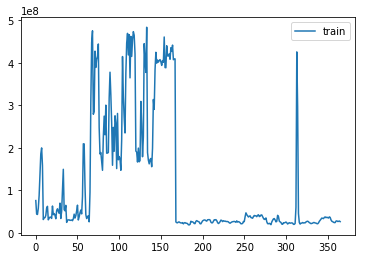

In [97]:
plt.plot(train_month_day_sum["meter_reading"], label="train")
plt.legend()
plt.show()

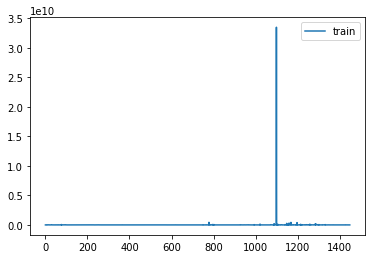

In [108]:
plt.plot(train_date_index_day_month.groupby("building_id")["meter_reading"].sum(), label="train")
plt.legend()
plt.show()

In [115]:
train_date_index_day_month.groupby("building_id")["meter_reading"].sum().iloc[1090:1110]

building_id
1090    1.737177e+07
1091    3.138784e+07
1092    2.188579e+07
1093    1.734444e+06
1094    1.535858e+07
1095    6.825111e+05
1096    2.504203e+05
1097    7.932593e+06
1098    5.225963e+06
1099    3.350620e+10
1100    2.821136e+07
1101    6.598437e+05
1102    1.612801e+07
1103    3.552327e+05
1104    9.432308e+07
1105    7.913918e+06
1106    2.659376e+06
1107    7.999353e+07
1108    2.380208e+07
1109    1.317111e+07
Name: meter_reading, dtype: float64

## ビル番号1099番が明らかにおかしい
meter_readingをmeter種類2番（蒸気メーター)の数値が3オーダーずれていたりするので、外れ値として除去する？

In [118]:
train_date_index_day_month[train_date_index_day_month["building_id"]==1099]

building_id  meter            timestamp  \
month day date                                                           
1     1   2016-01-01 00:00:00         1099      0  2016-01-01 00:00:00   
          2016-01-01 00:00:00         1099      2  2016-01-01 00:00:00   
          2016-01-01 01:00:00         1099      0  2016-01-01 01:00:00   
          2016-01-01 01:00:00         1099      2  2016-01-01 01:00:00   
          2016-01-01 02:00:00         1099      0  2016-01-01 02:00:00   
...                                    ...    ...                  ...   
12    31  2016-12-31 21:00:00         1099      2  2016-12-31 21:00:00   
          2016-12-31 22:00:00         1099      0  2016-12-31 22:00:00   
          2016-12-31 22:00:00         1099      2  2016-12-31 22:00:00   
          2016-12-31 23:00:00         1099      0  2016-12-31 23:00:00   
          2016-12-31 23:00:00         1099      2  2016-12-31 23:00:00   

                               meter_reading  
month day date                                
1     1   2016-01-01 00:00:00        282.248  
          2016-01-01 00:00:00    3241630.000  
          2016-01-01 01:00:00        282.248  
          2016-01-01 01:00:00    3241630.000  
          2016-01-01 02:00:00        284.864  
...                                      ...  
12    31  2016-12-31 21:00:00       4800.000  
          2016-12-31 22:00:00        266.022  
          2016-12-31 22:00:00       4896.000  
          2016-12-31 23:00:00        263.689  
          2016-12-31 23:00:00       5040.000  

[17566 rows x 4 columns]

メーターの種類が2番（蒸気メーター）のデータのメーター値を確認する。分布を確認し、1099番のビルのメーター値が異常値なのかを判断する。

In [152]:
meter_sum = pd.DataFrame(train_date_index_day_month[train_date_index_day_month["meter"]==2].groupby("building_id")["meter_reading"].sum()).reset_index()

In [160]:
meter_sum[meter_sum["meter_reading"]>1e9]

,building_id,meter_reading
143,1099,3.350114e+10


### 0.1e10より大きいものが1099番（教育機関）のみなのでid1099の蒸気メーターのデータを**異常値**として除去する

除去したデータを用いて、年間の日ごとのメーター値の合計の推移を表示してみる。

In [169]:
train_date_index[train_date_index["building_id"]==1099]

,building_id,meter,timestamp,meter_reading
timestamp_convert,,,,
2016-01-01 00:00:00,1099,0,2016-01-01 00:00:00,282.248
2016-01-01 00:00:00,1099,2,2016-01-01 00:00:00,3241630.000
2016-01-01 01:00:00,1099,0,2016-01-01 01:00:00,282.248
2016-01-01 01:00:00,1099,2,2016-01-01 01:00:00,3241630.000
2016-01-01 02:00:00,1099,0,2016-01-01 02:00:00,284.864
2016-01-01 02:00:00,1099,2,2016-01-01 02:00:00,262584.000
2016-01-01 03:00:00,1099,0,2016-01-01 03:00:00,280.287
2016-01-01 03:00:00,1099,2,2016-01-01 03:00:00,22632.000
2016-01-01 04:00:00,1099,0,2016-01-01 04:00:00,279.975


In [172]:
train_date_rm1099 = train_date_index[train_date_index["building_id"]!=1099]
train_date_index_day_month = train_date_rm1099.set_index([train_date_rm1099.index.month, train_date_rm1099.index.day, train_date_rm1099.index])
train_date_index_day_month.index.names = ["month", 'day', 'date']
train_month_day_sum = train_date_index_day_month.sum(level=['month', 'day']).reset_index()

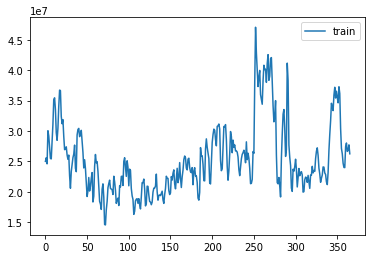

In [173]:
plt.plot(train_month_day_sum["meter_reading"], label="train")
plt.legend()
plt.show()

しかし、まだ周期性は見られないので時系列のノイズになりうるデータが潜んでないか確認してみる。

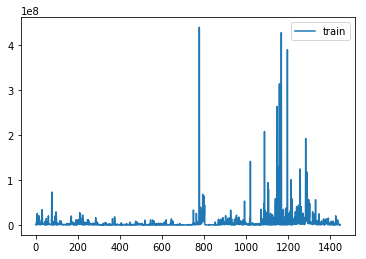

In [175]:
plt.plot(train_date_index_day_month.groupby("building_id")["meter_reading"].sum(), label="train")
plt.legend()
plt.show()

## 仮説
ビルの消費エネルギーは、そのビルの敷地面積に依存するのではないか？敷地面積が広ければそれだけ、電力などを使用していると考えられるので、meter_readingも大きくなると考えられる。

In [179]:
building_meta = pd.read_csv("building_metadata.csv")

In [181]:
train_day_month_meta = pd.merge(train_date_index_day_month, building_meta, on="building_id", how="inner")

In [190]:
train_build_meter = pd.DataFrame(train_day_month_meta.groupby("building_id")["meter_reading"].sum()).reset_index()

In [199]:
merge_data = pd.merge(train_build_meter, building_meta, on="building_id", how="inner")

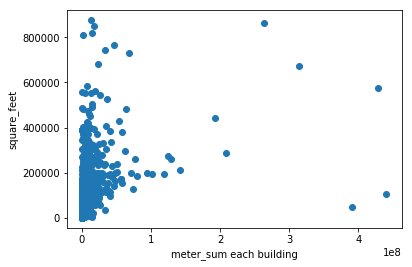

In [202]:
plt.scatter(merge_data["meter_reading"], merge_data["square_feet"])
plt.xlabel("meter_sum each building")
plt.ylabel("square_feet")
plt.show()

上の散布図からビルの敷地面積が大きくなればなるほど、メーター値も大きくなるという仮説は間違っていたことになる。
しかし、上の散布図は年間のメーター測定値の合計であり、測定回数が大きいほどメーター測定値は大きくなるので、厳密ではない。そこで、メーター測定回数を考慮したメーター測定値の指標を横軸にしてプロットしてみる

In [212]:
train_build_meter["count"] = train_day_month_meta.groupby("building_id")["building_id"].count()

In [384]:
train_build_meter

,building_id,meter_reading,count
0,0,1.286461e+06,8784.0
1,1,6.576176e+05,8784.0
2,2,1.278194e+05,8784.0
3,3,2.069071e+06,8784.0
4,4,8.578074e+06,8784.0
5,5,1.571848e+05,8784.0
6,6,5.627611e+05,8784.0
7,7,2.558355e+07,16051.0
8,8,2.256854e+06,8784.0
9,9,5.468687e+06,16049.0


In [216]:
merge_data = pd.merge(train_build_meter, building_meta, on="building_id", how="inner")
merge_data["average"] = merge_data["meter_reading"]/merge_data["count"]

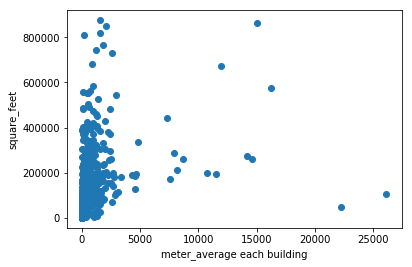

In [217]:
plt.scatter(merge_data["average"], merge_data["square_feet"])
plt.xlabel("meter_average each building")
plt.ylabel("square_feet")
plt.show()

In [305]:
over_35040 = list(merge_data[merge_data["count"]>35040]["building_id"])

In [310]:
merge_data[merge_data["building_id"].isin(over_35040)]

,building_id,meter_reading,count,site_id,primary_use,square_feet,year_built,floor_count,average
1241,1242,1.670976e+06,35116.0,14,Office,23871,NaN,NaN,47.584450
1249,1250,4.386123e+07,35136.0,14,Education,232139,NaN,NaN,1248.327428
1259,1260,5.130136e+06,35099.0,14,Office,86455,NaN,NaN,146.161873
1294,1295,1.543674e+07,35108.0,14,Office,115676,NaN,NaN,439.692856
1295,1296,2.790859e+06,35108.0,14,Office,8836,NaN,NaN,79.493536
1296,1297,6.781006e+06,35115.0,14,Office,21469,NaN,NaN,193.108530
1297,1298,5.652846e+07,35115.0,14,Education,171084,NaN,NaN,1609.809588
1298,1299,9.288589e+06,35136.0,14,Education,25401,NaN,NaN,264.361026
1301,1302,1.663966e+07,35128.0,14,Office,90411,NaN,NaN,473.686406


## 365×24×4　より多くのメーター測定データが存在しているビルIDがいるので、ダブりなどが存在していると考えられる。
ビル番号、測定時間、メーター種類でユニークになっていないものを確認してみる→ダブりではなくただの**閏年**

In [311]:
test = train_day_month_meta[train_day_month_meta["building_id"]==1259]
test["timestamp_convert"] = pd.to_datetime(test["timestamp"], format='%Y%m%d %H:%M')

/Users/shun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [335]:
366*24*4

35136

In [336]:
merge_data["count"].max()

35136.0

ただの閏年だった囧rz

## 日付や時間が同じであれば、メーター測定値も同じになるかの確認
もし、周期性がなく日付が同じでも月が異なれば、メーター測定値も異なるのであれば、時系列性を含んでいることになり時系列モデルをするべき。日付や月が同じならメーター測定値が同じであるなら、年ごとに異なるとは考えられにくいので
時系列モデルにする必要はなくなる。（2017年1月1日と2018年1月1日のメーター測定値は同じ予測なるようにモデリングする）

In [360]:
train_day_month_hour = train_date_index.set_index([train_date_index.index.month, train_date_index.index.day, train_date_index.index.hour])
train_day_month_hour.index.names = ["month", 'day', 'hour']

In [359]:
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_rows', 5000)

In [363]:
meter_count_temp = pd.DataFrame(train_day_month_hour.groupby(["day", "hour", "meter"])["meter_reading"].value_counts())

In [365]:
meter_count_temp = meter_count_temp.rename(columns={'meter_reading': 'count'})

## 仮に時系列モデルにするならいくつのモデルを作成することになるか確認する
building_idとmeterでgroupbyする

In [371]:
pd.set_option('display.max_rows', 100)
train.groupby(["building_id","meter"]).count()

timestamp  meter_reading
building_id meter                          
0           0           8784           8784
1           0           8784           8784
2           0           8784           8784
3           0           8784           8784
4           0           8784           8784
...                      ...            ...
1444        0           7445           7445
1445        0           7449           7449
1446        0           7472           7472
1447        0           7471           7471
1448        0           7452           7452

[2380 rows x 2 columns]

2380個の時系列モデルを作成する必要がありそう

In [374]:
train_build_meter[train_build_meter["meter_reading"]>1e8]

,building_id,meter_reading,count
778,778,4.404114e+08,16860.0
1021,1021,1.416654e+08,17338.0
1088,1088,2.082382e+08,26336.0
1147,1148,2.638549e+08,17567.0
1155,1156,1.284771e+08,8784.0
1158,1159,3.142415e+08,26352.0
1167,1168,4.286342e+08,26351.0
1196,1197,3.904002e+08,17568.0
1213,1214,1.007068e+08,8784.0
1257,1258,1.246654e+08,8784.0


In [404]:
building_meta[building_meta["building_id"].isin(anormaly_id)]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
778,6,778,Entertainment/public assembly,108339,NaN,NaN
1021,10,1021,Entertainment/public assembly,213762,NaN,2.0
1088,13,1088,Education,287594,NaN,NaN
1147,13,1147,Entertainment/public assembly,234476,NaN,NaN
1155,13,1155,Warehouse/storage,19059,NaN,NaN
1158,13,1158,Public services,294812,NaN,NaN
1167,13,1167,Office,52748,NaN,NaN
1196,13,1196,Entertainment/public assembly,57201,NaN,NaN
1213,13,1213,Warehouse/storage,39464,NaN,NaN
1257,14,1257,Office,61274,NaN,NaN


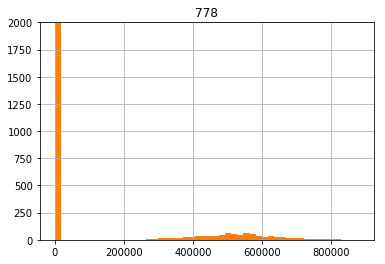

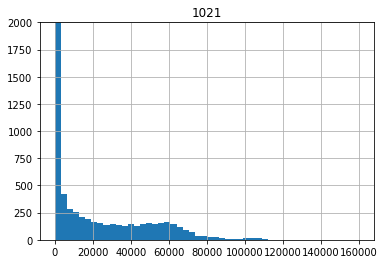

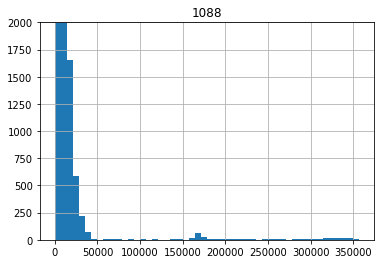

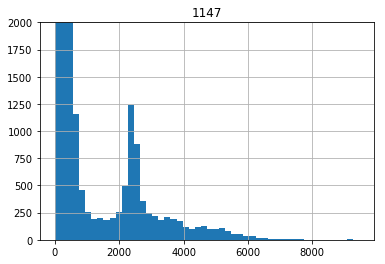

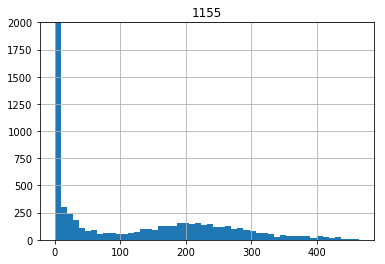

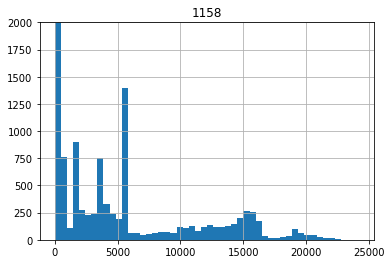

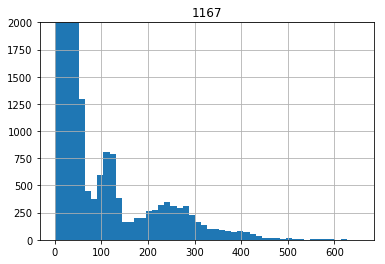

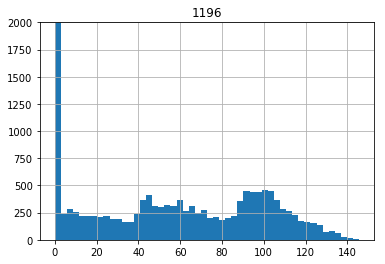

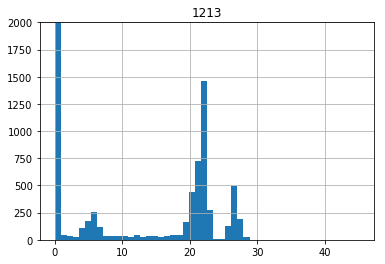

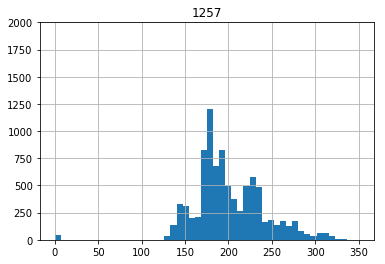

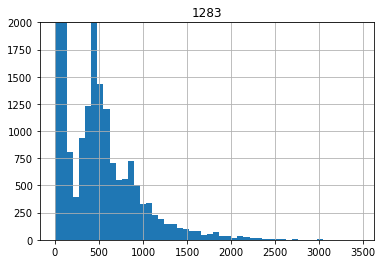

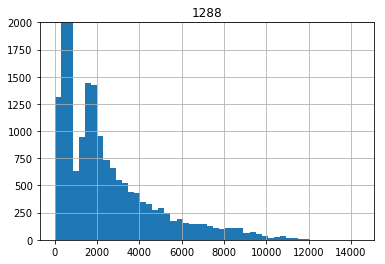

In [398]:
anormaly_id = list(train_build_meter[train_build_meter["meter_reading"]>1e8].index)
for i in anormaly_id:
    train[(train["building_id"]==i)]["meter_reading"].hist(bins=50)
    plt.ylim(0,2000)
    plt.title("{}".format(i))
    plt.show()

もし2380個の時系列モデルを作成する場合、ほとんどのモデルで学習データには存在しない期間がテストデータに含まれる。→予測精度上げるためには時系列方向に対する水増しは必須。
時系列方向に対する水増しの手間を削減するために、**ワンモデル**　にする。
ワンモデルなら、あるビルIDに対してある時刻のデータがなくともメタデータの特徴量などから、他のビルIDで一つでもその時刻のデータがあれば、ある程度の予測はできる。

時系列モデルをするわけではないので、水増しはとりあえず実施しない。検証データの用意の仕方に注意
- building_id(1449通り)で層別サンプリング
- timestamp(365×2×24通り)で層別サンプリング

## 本当にワンモデルで良いのかの確認

タイムスタンプが365*24全ての計測時点でメーター測定値があるビルが多いほど精度が上がる→ある時点でのメーターデータがないビルにおいては、これらのデータと特徴量との計算で次年度のその時点でのメーター測定値を予測するから
各ビルにおける、1年間のうちの測定データ数の割合などを確認する。

In [436]:
train_build_meter["meter_num"] = train_day_month_meta.groupby("building_id")["meter"].nunique()
train_build_meter["count_ratio"] = train_build_meter["count"]/(366*24*train_build_meter["meter_num"])

In [440]:
train_build_meter["count_ratio"].describe()

count    1447.000000
mean        0.967413
std         0.087303
min         0.054531
25%         0.994308
50%         0.999658
75%         1.000000
max         1.000000
Name: count_ratio, dtype: float64

In [449]:
len(train_build_meter[train_build_meter["count_ratio"]!=1])/len(train_build_meter)

0.7486187845303868

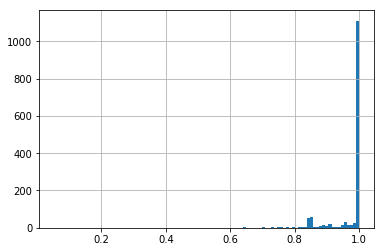

In [444]:
train_build_meter["count_ratio"].hist(bins=100)
plt.show()

1447ビルのうち、ほとんどのビル（約75%）が366日１時間ごとにメーターが測定されている。要するにデータが歯抜けになっているビル（時々メーターが測定されていないビル）は少数派ということが確認できる。
これくらいの量ならば歯抜けになっている時間の測定値もモデルで予測できそう。

In [450]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0000
1,1,0,2016-01-01 00:00:00,0.0000
2,2,0,2016-01-01 00:00:00,0.0000
3,3,0,2016-01-01 00:00:00,0.0000
4,4,0,2016-01-01 00:00:00,0.0000
5,5,0,2016-01-01 00:00:00,0.0000
6,6,0,2016-01-01 00:00:00,0.0000
7,7,0,2016-01-01 00:00:00,0.0000
8,8,0,2016-01-01 00:00:00,0.0000
9,9,0,2016-01-01 00:00:00,0.0000
